### Dependencies

In [1]:
%matplotlib inline
import numpy as np # Scientific computing 
import matplotlib.pyplot as plt # Plotting 
from astropy.stats import LombScargle # Basic Astronomy functions
import pandas as pd # Dataframe to store csv file content
import upsilon # Machine Learnign classification of light curve
import seaborn # Additional plotting
seaborn.set() # Set aesthetic parameters in one step.

-------------------------------
* WARNING: No pyFFTW detected *
-------------------------------


### Process Data

In [2]:
# Data from AAVSO
star = "r_105.21556.104"

# Load the data from csv file
light_curve = pd.read_csv("r_105.21556.104.mag", sep="\s+", names=["JD", "Magnitude", "Uncertainty"])

# Creating numpy array from pandas dataframe
mag = np.array(light_curve.fillna(0).Magnitude.tolist())
time = np.array(light_curve.fillna(0).JD.tolist())
err = np.array(light_curve.fillna(0).Uncertainty.tolist()) #fillna(0) replaces NaN with 0

### Raw Data Plot

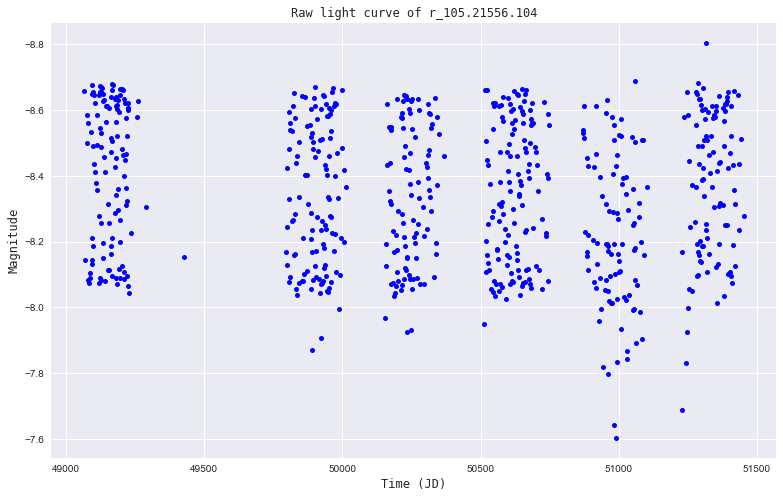

In [3]:
# Plot the raw data.
plt.figure(figsize=(13,8))
plt.plot(time, mag, marker='o', ls='None', ms=5, c='b')
plt.gca().invert_yaxis()
plt.xlabel("Time (JD)", size='medium', family = 'monospace')
plt.ylabel("Magnitude", size='medium', family = 'monospace')
plt.title("Raw light curve of " +star, size='medium', family = 'monospace')
plt.show()

### Lomb-Scargle Periodogram

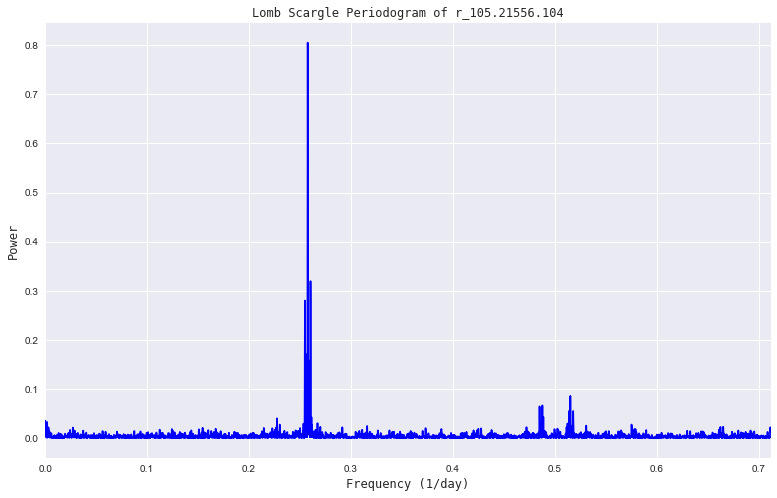

The best frequency is 0.257493239807


In [4]:
# If undertainty column in data is 0 then manually give uncertainity value to all points.
#err = 0.01

# nterms (1 by default) controls how many Fourier terms are used in the model.
frequency, power = LombScargle(time, mag, err, nterms = 1).autopower()
plt.figure(figsize=(13,8))
plt.plot(frequency, power, c='b')
plt.xlabel("Frequency (1/day)", size='medium', family = 'monospace')
plt.ylabel("Power", size='medium', family = 'monospace')
plt.title("Lomb Scargle Periodogram of " +star, size='medium', family = 'monospace')
plt.xlim([min(frequency), max(frequency)])
plt.savefig(star+'_power.png')
plt.show()

best_frequency = frequency[np.argmax(power)]
print("The best frequency is", best_frequency)

### Phase Plot with Best-Fit Sinusoid 

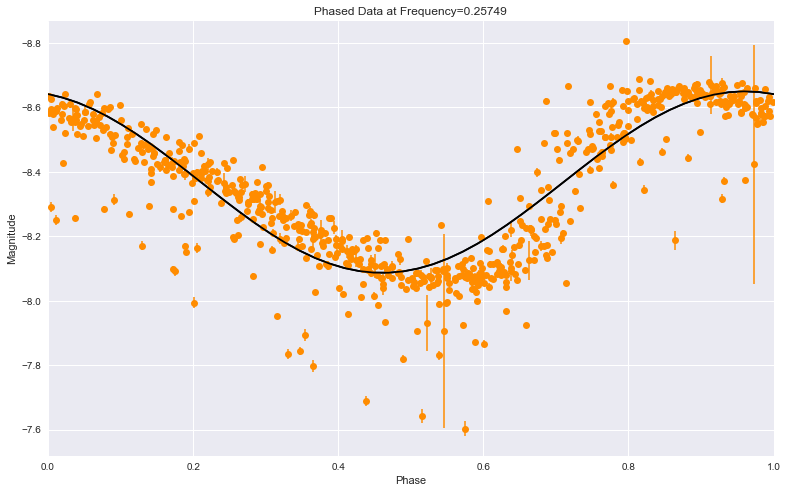

In [5]:
phase_fit = np.linspace(0, 1)
y_fit = LombScargle(time, mag, err, nterms=1).model(phase_fit/best_frequency, frequency=best_frequency)
phase = (time*best_frequency)%1

fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(phase_fit, y_fit, color='black', zorder=10)
ax.errorbar(phase, mag, err, fmt='o', mew=0, capsize=0, elinewidth=1.5, c='darkorange')
ax.plot(phase_fit, y_fit, color='black')
ax.invert_yaxis()
plt.xlim([0,1])
ax.set(xlabel='Phase',
       ylabel='Magnitude',
       title='Phased Data at Frequency={0:.5f}'.format(best_frequency))
plt.show()

### Classification

$\textbf{UPSILoN: AUtomated Classification for Periodic Variable Stars using MachIne LearNing.}$ This software package classifies a light curve into a class of a periodic variable star in an automatic manner. It can be applied to light curves from optical surveys regardless of survey-specific characteristics (e.g., photometric accuracy, sampling rate, duration, etc.) as long as the light curves satisfy a few broad conditions:

– it contains at least a few tens of data points that sample the characteristic variability well;

– the observation duration is more than a few weeks;

– the light curve is obtained in an optical band.

If multiple optical bands are available, UPSILoN can classify them separately. It does not use – or rely on – color information. UPSILoN is currently trained to classify into six types of periodic variables: δ Scuti, RR Lyrae, Cepheid, Type II Cepheid, eclipsing binary, long-period variable, and their subclasses. UPSILoN can also separate non-variables from these periodic variables, which is important because the majority of light curves from most time-series surveys are non-variables.

#### UPSILoN CLassification
$\textit{Variable Star Type}$: Long-Period Variables (LPV), Cepheid, Type II Cepheid, RR Lyrae, δ Scuti, and eclipsing binary.

$\textit{Subclass}$: Ex. Mira

$\textit{Phase of Evolution}$: Ex. asymptotic giant branch (AGB)

$\textit{Spectral Type}$: Ex. C

In [6]:
# time, mag, err are numpy arrays.
def classify_lightcurve(time, mag, err):
    # Refine data. This removes fluctuated data points in magnitudes.
    #date, mag, err = upsilon.utils.sigma_clipping(date, mag, err, threshold=3, iteration=1)
    
    # Load a classification model.
    rf_model = upsilon.load_rf_model()

    # Extract features
    e_features = upsilon.ExtractFeatures(time, mag)
    e_features.run()
    features = e_features.get_features()

    # Classify the light curve
    label, probability, flag = upsilon.predict(rf_model, features)
    print('Class: ',label,'\n', 
          'Probability: ',probability ,'\n', 
          'Flag: ',flag,'\n', # (0: successful classification) and (1: Suspicious classification)
          'Best Period: ',features['period'])
        
classify_lightcurve(time, mag, err)

C:\Users\A\Anaconda3\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\A\Anaconda3\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Class:  T2CEPH 
 Probability:  0.26 
 Flag:  0 
 Best Period:  3.8833863809
